## De-tabooing loneliness

In [1]:
import json
import pandas as pd
from datetime import datetime
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import requests

## Frequently used words such as articles, pronouns and prepositions
stopword_list = stopwords.words('english')
stopword_list.append('loneliness')
stopword_list.append('among')
stopword_list.append('\'s')

for punct_mark in string.punctuation:
    stopword_list.append(punct_mark)

This notebook collects information about academic publications using the Crossref API. Crossref is the organisation which mints and manages DOI for publications and datasets. 

More information about this API can be found on [Crossref's website](https://www.crossref.org/documentation/retrieve-metadata/rest-api/a-non-technical-introduction-to-our-api/)

The notebook also analyse the differences between publications in the STEM and in the SSH fields. The journals that are found using the Crossref API are linked to a domain using the [Journal Ranking Dataset](https://www.kaggle.com/datasets/xabirhasan/journal-ranking-dataset), which is available on Kaggle. The dataset lists journal titles, and links these to an academic discipline. This notebook works with revised version of this original dataset named "[journals_discipline.tsv](https://raw.githubusercontent.com/peterverhaar/dath_notebooks/main/Crossref/journals_discipline.tsv)"

In [2]:
df_journals = pd.read_csv('journals_discipline.tsv',sep='\t')

with open('jd.tsv','w',encoding='utf-8') as out:
    out.write('journal_title\tdomain\n')
    for i,row in df_journals.iterrows():
        title = row['journal_title']
        title = re.sub(r'\s+',' ',title)
        out.write(f"{title}\t{row['domain']}\n")

In [3]:
df_journals = pd.read_csv('jd.tsv',sep='\t')
journals_dict = dict(zip(df_journals['journal_title'],df_journals['domain']))

The cells below collect metadata about academic articles whose titles contain the word "loneliness" using the Crossref API. 

The base url of the API for academic publications is 

```
https://api.crossref.org/works
```

The API can be used with the following parameters:

* **query**: a term to search for. 
* **rows**: the number of publications to be included in the result set. The maximum number of rows is 500. 
* In the **filter**, it is possible to specify a start date using **from-pub-date**, and an end date using  **until-pub-date**. 



In [4]:
def get_items(json_data):
    
    rows = []
    
    for item in json_data:
        data = dict()

        date = ''
        date_parts = item['published']['date-parts'][0] 
        for i,part in enumerate(date_parts):
            date += f'{part}'
            if i < len(date_parts)-1:
                date += '-'
        data['date'] = date
        
        
        if re.search(r'\d{4}-\d{1,2}-\d{1,2}',date):
            year = datetime.strptime(date, '%Y-%m-%d').year
        elif re.search(r'\d{4}-\d{1,2}',date):
            year = datetime.strptime(date, '%Y-%m').year
        elif re.search(r'\d{4}',date):
            year = datetime.strptime(date, '%Y').year
            
        data['year'] = int(year)
        
        if 'author' in item:
            authors = []
            for author in item['author']:
                author_name = ''
                author_name += author.get('given','')
                author_name += ' ' + author.get('family','')
                authors.append(author_name.strip())
            if len(authors)>0:
                data['author'] = authors
        data['doi'] = item['DOI']
        data['publisher'] = item['publisher']
        
        if 'subject' in item:
      
            subjects = []
            for subject in item['subject']:
                subjects.append(subject)
            if len(subjects)>0:
                data['subject'] = subjects
        if 'abstract' in item:
            data['abstract'] = item['abstract']     
        if 'container-title' in item:
            journal_title = item['container-title'][0]
            journal_title = re.sub( '\s+' , ' ' , str(journal_title) )
            journal_title = re.sub( '\s+&amp;\s+' , ' & ' , str(journal_title) )
            data['journal'] = journal_title
            discipline = journals_dict[journal_title]
            data['discipline'] = discipline
        
        data['type']=item['type']
        title = item['title'][0]
        if 'subtitle' in item:
            title += ': ' + item['subtitle'][0]
        data['title']=title
        if 'link' in item:
            links = []
            for url in item['link']:
                links.append(url['URL'])
            if len(links)>0:
                data['link']=links
        rows.append(data)
        
    return rows

In [5]:

results = []

query_nr = 0

query = 'loneliness'
cursor = '*'
rows = 500
publ_type = 'journal-article'
start_date = '2004-01-01'
end_date = '2023-12-31'

headers = {'User-Agent':'mailto:p.a.f.verhaar@hum.leidenuniv.nl'}

url = f'https://api.crossref.org/works?query=%22{query}%22&cursor={cursor}&rows={rows}'

if re.search(r'\d',start_date) and re.search(r'\d',end_date):
    url += f'&filter=type:{publ_type},from-pub-date:{start_date},until-pub-date:{end_date}'

print(url)
    
response = requests.get(url,headers=headers)
json_data = response.json()

print( f"{json_data['message']['total-results']} results. ")
nr_items = len(json_data['message']['items'])

query_nr += 1
print(f"{query_nr}: items {(query_nr*rows)-rows}-{query_nr*rows}")

   
data = get_items(json_data['message']['items'])
results.extend(data)

next_cursor = ''
if 'next-cursor' in json_data['message']:
    next_cursor = json_data['message']['next-cursor']

while re.search( r'\w+' , next_cursor) and nr_items>0:

    url = f'https://api.crossref.org/works?query=%22{query}%22&cursor={next_cursor}&rows={rows}'

    if re.search(r'\d',start_date) and re.search(r'\d',end_date):
        url += f'&filter=type:{publ_type},from-pub-date:{start_date},until-pub-date:{end_date}'
        print(url)
    response = requests.get(url,headers=headers)
    json_data = response.json()
    query_nr += 1
    print(f"{query_nr}: items {(query_nr*rows)-rows}-{query_nr*rows}")
    
    nr_items = len(json_data['message']['items'])

    data = get_items(json_data['message']['items'])
    
    results.extend(data)

    next_cursor = ''
    if 'next-cursor' in json_data['message']:
        next_cursor = json_data['message']['next-cursor']

https://api.crossref.org/works?query=%22loneliness%22&cursor=*&rows=500&filter=type:journal-article,from-pub-date:2004-01-01,until-pub-date:2024-01-01
9107 results. 
1: items 0-500
https://api.crossref.org/works?query=%22loneliness%22&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAbekzRFmx3VDZUUHY5VHlhdThmaGVtbFhBOVEAAAAAB5NImxZwMUUtd3VRM1RzU3RxcXpMUVg3MFZBAAAAABulQb8WTUpsaGN0RGFRbS1yN0ZYWTJ3MG5pUQAAAAAYPqORFmZPZjNDVWhLUnh1RDFtUWM4WFIzUHcAAAAACYzqehZISVAwTVh0alJ0eUZkTUoyOXBJdkVBAAAAAByVeykWY2hqVHNHWVVRYkdqcWtJNUJXbkk4Zw==&rows=500&filter=type:journal-article,from-pub-date:2004-01-01,until-pub-date:2024-01-01
2: items 500-1000
https://api.crossref.org/works?query=%22loneliness%22&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAbekzRFmx3VDZUUHY5VHlhdThmaGVtbFhBOVEAAAAAB5NImxZwMUUtd3VRM1RzU3RxcXpMUVg3MFZBAAAAABulQb8WTUpsaGN0RGFRbS1yN0ZYWTJ3MG5pUQAAAAAYPqORFmZPZjNDVWhLUnh1RDFtUWM4WFIzUHcAAAAACYzqehZISVAwTVh0alJ0eUZkTUoyOXBJdkVBAAAAAByVeykWY2hqVHNHWVVRYkdqcWtJNUJXbkk4Zw==&rows=500&filter=type:journal-article,from-pub

20: items 9500-10000


The results are saved in a file named [articles_loneliness.json](https://raw.githubusercontent.com/peterverhaar/dath_notebooks/main/Crossref/articles_loneliness.json)

In [6]:
with open(f'articles_{query}.json', 'w') as f:
    json.dump(results, f)

In [7]:
file_name = 'articles_loneliness.json'

json_file = open(file_name)
json_data = json.load(json_file)

print(f'The file contains metadata about {len(json_data)} publications.')

The file contains metadata about 9107 publications.


## Number of publications per year

## All publications

How many journal articles that have been assigned DOI have a title containing the word 'loneliness'?

In [30]:
json_file = open('articles_loneliness.json',encoding='utf-8')
articles = json.load(json_file)

data = []
for article in articles:
    if article['year'] < 2024:
        row = []
        row.append(article['year'])
        row.append(article['discipline'])
        row.append(article['journal'])
        row.append(article['title'])
        data.append(row)

df = pd.DataFrame(data,columns=['year','discipline','journal','title'])

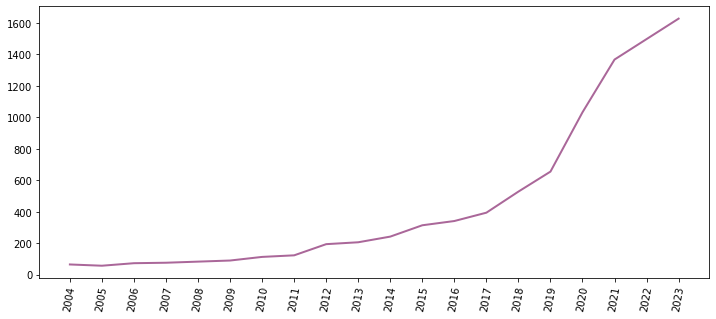

In [16]:
dates_counter = Counter(df['year'].astype(int))

x_axis = []
y_axis = []

for year in sorted(dates_counter.keys()):
    x_axis.append(str(year))
    y_axis.append(dates_counter.get(year))
    
fig = plt.figure( figsize = ( 12, 5))
ax = sns.lineplot( x= x_axis, y=y_axis, 
                  color= '#AA6799', linestyle='solid',linewidth=2 )
plt.xticks(rotation= 80)
plt.show()

The visualisation above shows the absolute counts, and this pattern may not be fully reliable because of this reason. It may also be the case that CrossRef has simply begun to assign more DOIs overall over the course of the past few years. In an attempt to present a more reliable picture, the cells below collect data about the total number of DOIs assigned to journal articles on an annual basis. The number of articles on loneliness is subsequently divided by the total number of articles that have been given a DOI. 

In [17]:
nr_dois = dict()

for year in range(2004,2024):

    rows = 0
    publ_type = 'journal-article'
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    headers = {'User-Agent':'mailto:p.a.f.verhaar@hum.leidenuniv.nl'}

    url = f'https://api.crossref.org/types/{publ_type}/works?rows={rows}'

    if re.search(r'\d',start_date) and re.search(r'\d',end_date):
        url += f'&filter=type:{publ_type},from-pub-date:{start_date},until-pub-date:{end_date}'

    response = requests.get(url,headers=headers)
    if response: 
        json_data = response.json()
        total_items = json_data['message']['total-results']
        nr_dois[year] = total_items


In [18]:
for year in nr_dois:
    print(f'{year}: {nr_dois[year]} DOIs for journal articles in total')

2004: 1669025 DOIs for journal articles in total
2005: 1744164 DOIs for journal articles in total
2006: 1902348 DOIs for journal articles in total
2007: 1991954 DOIs for journal articles in total
2008: 2095884 DOIs for journal articles in total
2009: 2239541 DOIs for journal articles in total
2010: 2358946 DOIs for journal articles in total
2011: 2575526 DOIs for journal articles in total
2012: 2778812 DOIs for journal articles in total
2013: 3000884 DOIs for journal articles in total
2014: 3164215 DOIs for journal articles in total
2015: 3324880 DOIs for journal articles in total
2016: 3552742 DOIs for journal articles in total
2017: 3756130 DOIs for journal articles in total
2018: 4056794 DOIs for journal articles in total
2019: 4380907 DOIs for journal articles in total
2020: 4834343 DOIs for journal articles in total
2021: 5204448 DOIs for journal articles in total
2022: 5356989 DOIs for journal articles in total
2023: 5330671 DOIs for journal articles in total


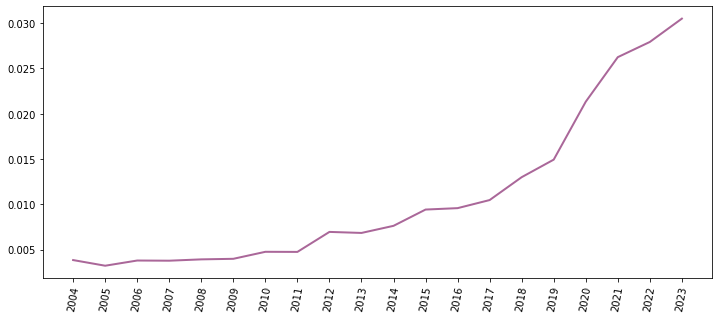

In [19]:
dates_counter = Counter(df['year'].astype(int))

x_axis = []
y_axis = []

for year in sorted(dates_counter.keys()):
    x_axis.append(str(year))
    y_axis.append( (dates_counter.get(year)/nr_dois[year])*100 )
    
fig = plt.figure( figsize = ( 12, 5))
ax = sns.lineplot( x= x_axis, y=y_axis, 
                  color= '#AA6799', linestyle='solid',linewidth=2 )
plt.xticks(rotation= 80)
plt.show()

## Broken down by discipline

In [20]:
ssh_counter = Counter( df.query( 'discipline=="SSH" ' )['year'] )
stem_counter = Counter( df.query( 'discipline=="STEM" ' )['year'] )

year_min = df['year'].astype(int).min()
year_max = df['year'].astype(int).max()

data = []
for year in range(year_min,year_max+1):
    row = []
    row.append(str(year))
    row.append((ssh_counter.get(year,0)/nr_dois[year])*100)
    row.append('SSH')
    data.append(row)
    
    row = []
    row.append(str(year))
    row.append((stem_counter.get(year,0)/nr_dois[year])*100)
    row.append('STEM')
    data.append(row)
    
df_discipline = pd.DataFrame(data,columns=['year','count','discipline'])

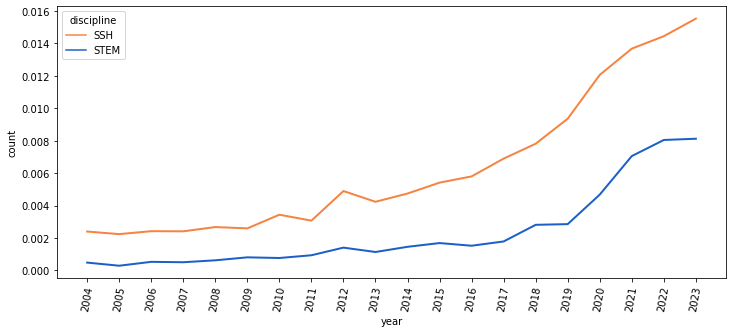

In [21]:
colours = ['#f58442','#1c60c7']

fig = plt.figure( figsize = ( 12, 5))
ax = sns.lineplot( data = df_discipline, 
                  x= 'year', y='count', 
                  hue='discipline', palette = colours,
                  linestyle='solid',linewidth=2 )
plt.xticks(rotation= 80)
plt.show()

## Journals

Which STEM and SSH journals have published the highest number of publications on loneliness?

In [26]:
def singular_plural(noun,count):
    if count>1:
        noun += 's'
    return noun

### Social Sciences and Humanities

In [27]:
journals_counter = Counter(df.query( 'discipline=="SSH" ' )['journal'])

for journal,count in journals_counter.most_common(30):
    print(f"{journal} ({count} {singular_plural('publication',count)})")

Innovation in Aging (430 publications)
Frontiers in Psychology (123 publications)
Aging & Mental Health (120 publications)
Current Psychology (82 publications)
International Psychogeriatrics (57 publications)
Ageing and Society (51 publications)
The American Journal of Geriatric Psychiatry (50 publications)
Frontiers in Psychiatry (48 publications)
Journal of Social and Personal Relationships (47 publications)
Health & Social Care in the Community (44 publications)
International Journal of Geriatric Psychiatry (44 publications)
Computers in Human Behavior (42 publications)
Social Psychiatry and Psychiatric Epidemiology (42 publications)
Psychiatry Research (41 publications)
Psychological Reports (39 publications)
Social Science & Medicine (35 publications)
The Journal of Psychology (35 publications)
Journal of the American Geriatrics Society (34 publications)
European Psychiatry (33 publications)
The Proceedings of the Annual Convention of the Japanese Psychological Association (33 pub

Which articles can be find in the journal with the highest number of articles on the topic under investigation?

In [32]:
journal_most_publications = journals_counter.most_common(1)[0][0]
count = 0
for i,row in df.query( f"journal == '{journal_most_publications}'" ).iterrows():
    count += 1
    if count == 30:
        break
    print(f'"{row["title"].title()} ({row["year"]})"')

"What Is Loneliness: Insights From The Bbc Loneliness Experiment (2019)"
"Changes In Loneliness And Patterns Of Loneliness Among Older People (2018)"
"Interest Group Session—Loneliness And Social Isolation: The Language(S) Of Loneliness (2019)"
"Companionship To Address Quality Of Life And Loneliness Among Older Adults With Severe Loneliness (2022)"
"How Do Lonely Older People Talk About Loneliness? Preliminary Analysis Of The Bbc Loneliness Experiment (2022)"
"Is There A Worry Advantage? The Role Of Fear Of Loneliness In Old Age In Loneliness Preventive Activities (2023)"
"Loneliness And Social Engagement: The Unique Roles Of State And Trait Loneliness For Daily Prosocial Behaviors (2020)"
"How Is Daily Social Interaction Related To Loneliness In Older Adults? The Roles Of Trait Loneliness And Personality. (2021)"
"Talking About Loneliness (2019)"
"Social Isolation, Loneliness, And Men'S Health (2019)"
"Social Isolation And Loneliness: Strengthening Education And Training (2020)"
"Lon

### Science, technology, engineering, and mathematics

In [33]:
journals_counter = Counter(df.query( 'discipline=="STEM" ' )['journal'])

for journal,count in journals_counter.most_common(30):
    print(f"{journal} ({count} {singular_plural('publication',count)})")

International Journal of Environmental Research and Public Health (203 publications)
European Journal of Public Health (50 publications)
Alzheimer's & Dementia (50 publications)
BMC Geriatrics (48 publications)
Journal of Affective Disorders (46 publications)
Archives of Gerontology and Geriatrics (42 publications)
Frontiers in Public Health (39 publications)
BMC Public Health (36 publications)
Scientific Reports (33 publications)
Healthcare (32 publications)
Academy of Management Proceedings (30 publications)
Geriatric Nursing (23 publications)
International Journal of Mental Health and Addiction (20 publications)
Gerontechnology (18 publications)
Nursing Older People (17 publications)
Journal of the American Medical Directors Association (15 publications)
Nursing Standard (14 publications)
Gerontology and Geriatric Medicine (14 publications)
Perspectives in Public Health (13 publications)
Journal of Public Health (13 publications)
Journal of Clinical Nursing (13 publications)
Journal

In [34]:
journal_most_publications = journals_counter.most_common(1)[0][0]
count = 0
for i,row in df.query( f"journal == '{journal_most_publications}'" ).iterrows():
    count += 1
    if count == 30:
        break
    print(f'"{row["title"].title()} ({row["year"]}) {row["journal"]}"')

"Loneliness At Universities: Determinants Of Emotional And Social Loneliness Among Students (2018) International Journal of Environmental Research and Public Health"
"Loneliness And Emancipation: A Multilevel Analysis Of The Connection Between Gender Inequality, Loneliness, And Social Isolation In The Issp 2017 (2022) International Journal of Environmental Research and Public Health"
"The Missing Measure Of Loneliness: A Case For Including Neededness In Loneliness Scales (2021) International Journal of Environmental Research and Public Health"
"Loneliness In Older Migrants: Exploring The Role Of Cultural Differences In Their Loneliness Experience (2023) International Journal of Environmental Research and Public Health"
"Exploring The Frequency, Intensity, And Duration Of Loneliness: A Latent Class Analysis Of Data From The Bbc Loneliness Experiment (2021) International Journal of Environmental Research and Public Health"
"Tell Me About Loneliness: Interviews With Young People About Wha

## Collocations

Which other words are used in titles, besides "loneliness"? These other words may give an impressinon of the broader contexts of thi word. The cells below established the 15 words that are used most frequently in journal titles, besides "loneliness".

Articles in STEM journals and SSH journals are considered separately. 

### SSH Journals

In [35]:
for year in sorted(df['year'].astype(int).unique()):
    freq = Counter()
    print(f'\n\n{year}\n')

    for title in df.query( f'discipline=="SSH" and year=={year}' )['title']:
        words = word_tokenize(title)
        words = [word.lower() for word in words if word.lower() not in stopword_list]
        freq.update(words)

    freq.update(words)

    for word,count in freq.most_common(15):
        print(f'{word} {count}')



2004

social 11
children 6
study 6
older 5
age 4
emotional 4
canadian 4
isolation 4
life 3
longitudinal 3
adults 3
adaptation 3
brazilian 3
chinese 3
italian 3


2005

social 10
older 6
students 6
people 5
attachment 5
depression 4
styles 3
elderly 3
life 3
adult 3
study 3
skills 3
immune 3
response 3
college 3


2006

social 13
older 10
people 7
women 5
attachment 5
life 4
relationship 4
support 4
study 4
kate 4
health 3
satisfaction 3
adolescents 3
psychological 3
physical 3


2007

social 13
older 7
adults 7
students 4
relationship 4
internet 3
use 3
women 3
children 3
educational 3
gender 3
emotional 3
life 3
using 2
alzheimer 2


2008

social 12
life 6
older 6
relationship 5
study 5
satisfaction 4
students 4
health 4
depression 4
factors 4
well 3
family 3
university 3
people 3
effect 3


2009

social 20
older 8
life 7
students 6
university 6
adults 5
effect 5
support 4
factors 4
longitudinal 4
use 4
later 4
lt 4
gt 4
relation 4


2010

social 21
older 14
students 10
’ 9
adults 8

### STEM Journals

In [36]:
for year in sorted(df['year'].astype(int).unique()):
    freq = Counter()
    print(f'\n\n{year}\n')

    for title in df.query( f'discipline=="STEM" and year=={year}' )['title']:
        words = word_tokenize(title)
        words = [word.lower() for word in words if word.lower() not in stopword_list]
        freq.update(words)

    freq.update(words)

    for word,count in freq.most_common(10):
        print(f'{word} {count}')



2004

older 3
indoor 2
gardening 2
adults 2
effects 2
socialization 2
activities 2
daily 2
living 2
technology 1


2005

social 3
interventions 3
combating 2
persons 2
severe 2
mental 2
illness 2
network 2
characteristics 2
effectiveness 2


2006

older 5
people 3
depression 3
meta-analytic 2
study 2
predictors 2
adolescence 2
loss 2
parents 2
childhood 2


2007

study 4
social 4
support 3
dying 2
care 2
relationship 2
specialization 2
amongst 2
sources 2
receivers 2


2008

older 3
school 2
setting 2
people 2
electrons 2
bc1 2
complex 2
leisure 2
women 2
rheumatoid 2


2009

health 6
people 5
psychosocial 4
older 4
social 4
effects 4
living 3
persons 3
support 3
group 3


2010

older 4
study 4
elderly 4
adults 3
cancer 3
people 3
living 3
differences 2
increase 2
patients 2


2011

older 7
health 5
relationship 4
people 3
living 3
support 3
work 2
employee 2
performance 2
fun 2


2012

older 18
social 11
adults 8
elderly 8
depression 7
living 6
support 6
risk 5
rural 4
people 4


20